In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedPipeline
from text3d2video.attn_processors.style_aligned_attn import (
    StyleAlignedAttentionProcessor,
)
from diffusers import DDIMScheduler
from diffusers import DPMSolverMultistepScheduler

sd_repo = "runwayml/stable-diffusion-v1-5"

dtype = torch.float16
device = torch.device("cuda")

pipe: StyleAlignedPipeline = StyleAlignedPipeline.from_pretrained(
    sd_repo, torch_dtype=dtype
).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
from text3d2video.sd_feature_extraction import AttnType, BlockType, find_attn_layers

all_attn_modules = find_attn_layers(pipe.unet, return_as_string=False)

up_sa_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.UP, BlockType.MID],
    layer_types=[AttnType.SELF_ATTN],
    return_as_string=False,
)

100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


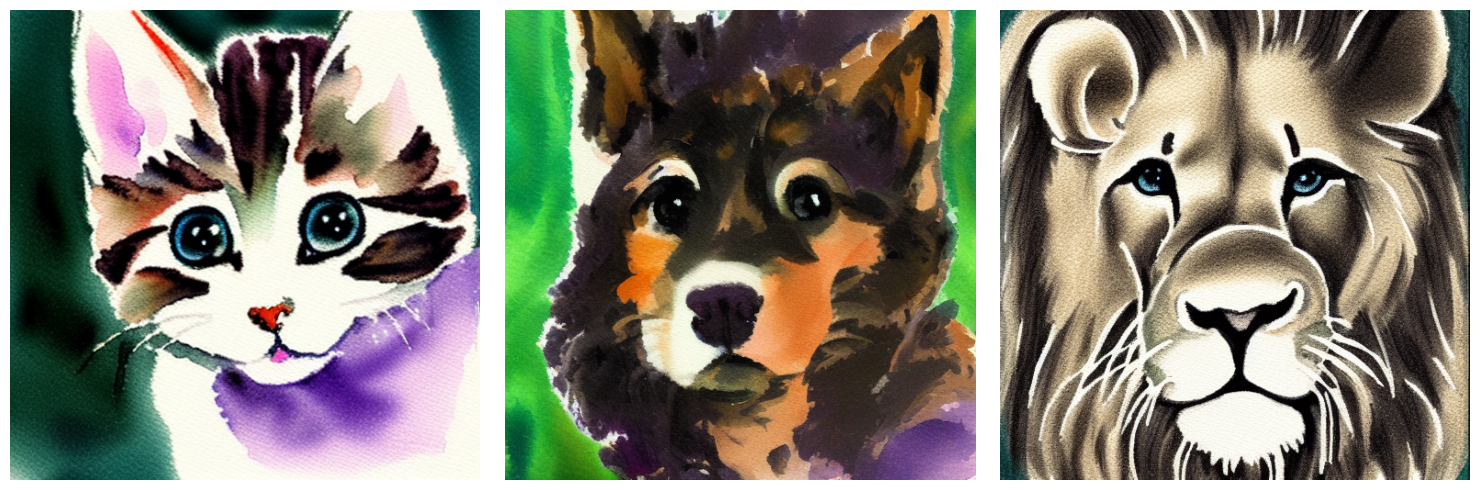

In [287]:
from pathlib import Path
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedLogger

prompts = ["A kitten watercolor", "Dog", "Lion Drawing"]

attend_to = 'both'
ref_index = 0

attn_processor = StyleAlignedAttentionProcessor(
    pipe.unet,
    ref_index=ref_index,
    attend_to=attend_to,
    adain_self_features=False,
    layers=[l.module_path() for l in up_sa_layers],
)

pipe.unet.set_attn_processor(attn_processor)
pipe.attn_processor = attn_processor

gen = torch.Generator(device=device)
gen.manual_seed(0)

logger = StyleAlignedLogger(Path("data.h5"), enabled=True)
logger.path_greenlist = [l.module_path() for l in all_attn_modules]
logger.delete_data()
logger.begin_recording()

ims = pipe(
    prompts,
    num_inference_steps=20,
    generator=gen,
    guidance_scale=10,
    logger=logger,
)

display_ims(ims, scale=5)

logger.end_recording()

In [288]:
logger = pipe.logger
ts = logger.noise_level_greenlist
denoising_ts = ts[0:-1]

In [289]:
from numpy import sqrt
from text3d2video.utilities.attn_vis import calc_attn_weights_all_heads

layer = up_sa_layers[-4].module_path()
t = denoising_ts[4]
frame = 1

qry = logger.attn_writer.read_qry(t, frame, layer)
key = logger.attn_writer.read_key(t, frame, layer)
weights = calc_attn_weights_all_heads(qry, key)
res = int(sqrt(weights.shape[0]))

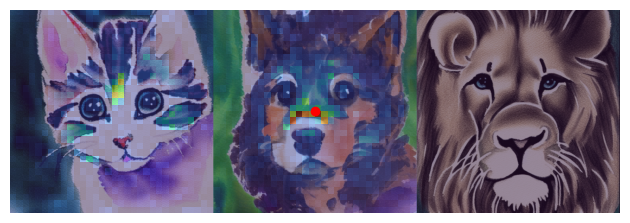

In [290]:
from einops import rearrange
from matplotlib import pyplot as plt
from torch import Tensor

from text3d2video.utilities.attention_visualization import (
    concatenate_images,
    coord_to_pixel,
    pixel_coord_flattened,
    reshape_concatenated,
)


if attend_to == "all":
    attended_to = torch.arange(len(ims))
if attend_to == "self":
    attended_to = torch.tensor([frame])
if attend_to == "reference":
    attended_to = torch.tensor([ref_index])
if attend_to == "both":
    attended_to = torch.tensor([frame, ref_index])

coord = Tensor([0.5, 0.5])

n_ims = len(ims)

# find weight sfor given query coord
coord_pix = coord_to_pixel(coord, (res, res))
coord_pix_flat = pixel_coord_flattened(coord_pix, (res, res))
row = weights[coord_pix_flat, :]
weights_2D = reshape_concatenated(row.unsqueeze(-1), layer_res=res)[0]

# split weights corresponding to each image
weights_split = rearrange(weights_2D, "h (n w) -> n h w", n=len(attended_to))

# obtain weights across whole image
all_weights = torch.zeros((n_ims, res, res))
for i, idx in enumerate(attended_to):
    all_weights[idx] = weights_split[i]
all_weights_2D = rearrange(all_weights, "n h w -> h (n w)")

ims_concat = concatenate_images(ims)

coord_shifted = coord + Tensor([frame, 0])

plt.imshow(ims_concat, extent=[0, n_ims, 0, 1])
plt.imshow(all_weights_2D, extent=[0, n_ims, 0, 1], alpha=0.5, cmap="turbo")
plt.axis("off")
plt.scatter(coord_shifted[0], coord_shifted[1], c="red")
plt.tight_layout()

(0.0, 1.575, 0.0, 1.0)

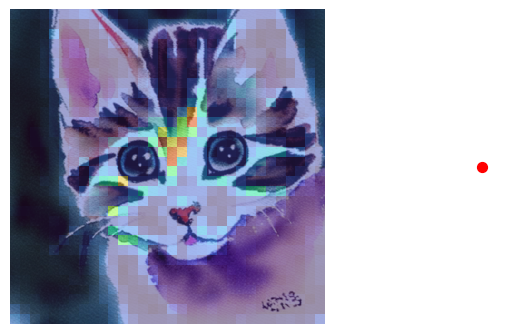

In [ ]:
from torch import Tensor
from text3d2video.utilities.attention_visualization import (
    concatenate_images,
    coord_to_pixel,
    pixel_coord_flattened,
    reshape_concatenated,
)


if attend_to == "all":
    kv_ims = ims
if attend_to == "self":
    kv_ims = [ims[frame]]
if attend_to == "reference":
    kv_ims = [ims[ref_index]]
if attend_to == "both":
    kv_ims = [ims[ref_index], ims[frame]]

coord = Tensor([0.5, 0.5])

coord_pix = coord_to_pixel(coord, (res, res))
coord_pix_flat = pixel_coord_flattened(coord_pix, (res, res))
row = weights[coord_pix_flat, :]
weights_2D = reshape_concatenated(row.unsqueeze(-1), layer_res=res)[0]

kv_im = concatenate_images(kv_ims)

plt.imshow(kv_im, extent=[0, len(kv_ims), 0, 1])
plt.imshow(weights_2D, cmap="turbo", alpha=0.5, extent=[0, len(kv_ims), 0, 1])

coord_adjusted = coord + torch.Tensor([frame, 0])
plt.scatter(x=coord_adjusted[0], y=coord_adjusted[1], c="red", s=50)

plt.axis('off')

0


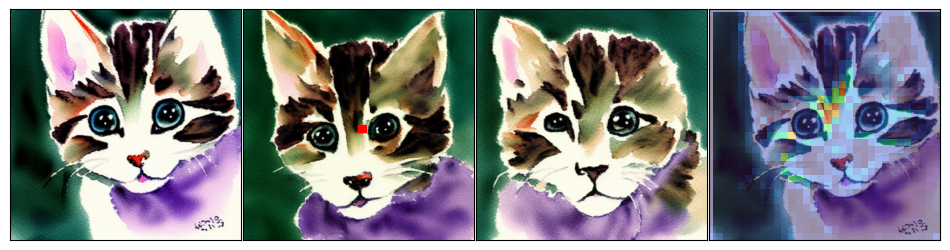

In [149]:
from torch import Tensor
from text3d2video.utilities.attention_visualization import (
    concatenate_images,
    make_gridspec_figure,
)
from text3d2video.utilities.attn_vis import plot_sa_weights

frame = 1
coord = Tensor([0.5, 0.5])

# get KV image
if attend_to == "all":
    kv_ims = ims
if attend_to == "self":
    kv_ims = [ims[frame]]
if attend_to == "reference":
    kv_ims = [ims[ref_index]]
if attend_to == "both":
    kv_ims = [ims[ref_index], ims[frame]]
kv_im = concatenate_images(kv_ims)

fig, gs = make_gridspec_figure(
    1, len(ims) + 1, height_ratios=[1], width_ratios=[1, 1, 1, len(kv_ims)], scale=3
)


for i in range(len(ims)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(ims[i])

    ax.set_xticks([])
    ax.set_yticks([])

    if i == frame:
        ax_qry = ax

ax_kv = fig.add_subplot(gs[0, len(ims)])
ax_kv.set_xticks([])
ax_kv.set_yticks([])

plot_sa_weights(ax_qry, ax_kv, weights, coord, qry_img=ims[frame], kv_img=kv_im, alpha=0.5)
